<a href="https://colab.research.google.com/github/Dasrunaik/Custom-Sentiment-Analysis-using-BERT/blob/main/HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd

In [85]:
df=messages=pd.read_csv('/content/SMSSpamCollection.txt',sep='\t',names=['label','message'])

In [86]:
df.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [87]:
df.columns

Index(['label', 'message'], dtype='object')

In [88]:
df.shape

(5572, 2)

In [89]:
df["label"].value_counts()

,count
label,
ham,4825
spam,747


In [90]:
df.isnull().sum()

,0
label,0
message,0


In [91]:
df.duplicated().sum()

np.int64(403)

In [92]:
df.drop_duplicates(inplace=True)

In [93]:
df.duplicated().sum()

np.int64(0)

In [94]:
df.describe()

,label,message
count,5169,5169
unique,2,5169
top,ham,Rofl. Its true to its name
freq,4516,1


In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

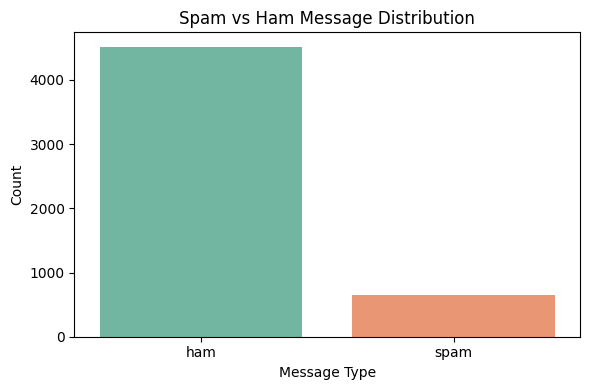

In [96]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, hue='label', palette='Set2', legend=False)
plt.title('Spam vs Ham Message Distribution')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("spam_vs_ham_distribution.png")  # or use plt.show() in notebooks


In [97]:
df['labels']=df['label'].apply(lambda x: 1 if x=='spam' else 0)

In [98]:
df.head(10)

,label,message,labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


In [99]:
X=list(df['message'])


In [100]:
y=list(df['labels'])

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [102]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [103]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer((X_test), truncation=True, padding=True)

In [104]:
import torch
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(y_train))

In [105]:
class SentientDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [106]:
train_dataset = SentientDataset(train_encodings, list(y_train))
test_dataset = SentientDataset(test_encodings, list(y_test))

In [107]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [108]:
model=DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [109]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [110]:
training_args=TrainingArguments(output_dir='./results',
                                num_train_epochs=2,
                                learning_rate=2e-5,
                                per_device_train_batch_size=8,
                                per_device_eval_batch_size=8,
                                weight_decay=0.01,
                                logging_dir='./logs',
                                logging_steps=10,)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [111]:
trainer=Trainer(model=model,args=training_args,train_dataset=train_dataset,eval_dataset=test_dataset)

In [112]:
trainer.train()

Step,Training Loss
10,0.563100
20,0.361800
30,0.248100
40,0.124300
50,0.052500
60,0.023500
70,0.047200
80,0.012800
90,0.088200
100,0.110200


TrainOutput(global_step=1034, training_loss=0.0577625205537225, metrics={'train_runtime': 225.6629, 'train_samples_per_second': 36.648, 'train_steps_per_second': 4.582, 'total_flos': 472864629885960.0, 'train_loss': 0.0577625205537225, 'epoch': 2.0})

In [113]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.01994914375245571,
 'eval_runtime': 6.4672,
 'eval_samples_per_second': 159.882,
 'eval_steps_per_second': 20.101,
 'epoch': 2.0}

Prediction

In [114]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[ 3.4006197, -4.2258244],
       [ 3.3821082, -4.1992846],
       [ 3.1722152, -3.9846787],
       ...,
       [ 3.3028882, -4.1768723],
       [ 3.3275824, -4.2045884],
       [ 3.2142088, -4.0621934]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.01994914375245571, 'test_runtime': 6.6696, 'test_samples_per_second': 155.031, 'test_steps_per_second': 19.491})

In [115]:
trainer.predict(test_dataset)[1].shape

(1034,)

In [116]:
output=trainer.predict(test_dataset)[1]

In [117]:
output

array([0, 0, 0, ..., 0, 0, 0])

In [118]:
from sklearn.metrics import confusion_matrix,classification_report

In [119]:
cm=confusion_matrix(y_test,output)
cm

array([[896,   0],
       [  0, 138]])

In [120]:
cr=classification_report(y_test,output)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       896
           1       1.00      1.00      1.00       138

    accuracy                           1.00      1034
   macro avg       1.00      1.00      1.00      1034
weighted avg       1.00      1.00      1.00      1034



In [131]:
model.save_pretrained("saved_distilbert_model")
tokenizer.save_pretrained("saved_distilbert_model")

('saved_distilbert_model/tokenizer_config.json',
 'saved_distilbert_model/special_tokens_map.json',
 'saved_distilbert_model/vocab.txt',
 'saved_distilbert_model/added_tokens.json',
 'saved_distilbert_model/tokenizer.json')

In [122]:
pip install streamlit

Streamlit deployment

In [125]:
MODEL_NAME='distilbert-base-uncased'
tokenizer=DistilBertTokenizer.from_pretrained(MODEL_NAME)
model=DistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [128]:
!zip -r saved_distilbert_model.zip saved_distilbert_model/


updating: saved_distilbert_model/ (stored 0%)
updating: saved_distilbert_model/config.json (deflated 45%)
updating: saved_distilbert_model/vocab.txt (deflated 53%)
updating: saved_distilbert_model/tokenizer_config.json (deflated 75%)
updating: saved_distilbert_model/model.safetensors (deflated 8%)
updating: saved_distilbert_model/special_tokens_map.json (deflated 42%)
updating: saved_distilbert_model/tokenizer.json (deflated 71%)


In [129]:
model.save_pretrained("saved_distilbert_model")
tokenizer.save_pretrained("saved_distilbert_model")


('saved_distilbert_model/tokenizer_config.json',
 'saved_distilbert_model/special_tokens_map.json',
 'saved_distilbert_model/vocab.txt',
 'saved_distilbert_model/added_tokens.json',
 'saved_distilbert_model/tokenizer.json')

In [132]:
%%writefile app.py
import streamlit as st
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

st.set_page_config(page_title="Spam Detector with DistilBERT", layout="centered")
st.title("📩 SMS Spam Detection using Hugging Face DistilBERT")
st.markdown("Enter an SMS message to classify it as **Spam** or **Ham (Not Spam)**.")

# Load your saved model
MODEL_PATH = "saved_distilbert_model"
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)

# Input box
text = st.text_area("✏️ Enter a message:", height=100)

# Predict
if st.button("🚀 Classify"):
    if not text.strip():
        st.warning("Please enter a valid message.")
    else:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            prediction = torch.argmax(logits, dim=1).item()
        if prediction == 1:
            st.error("🔴 This message is classified as **Spam**.")
        else:
            st.success("🟢 This message is classified as **Ham (Not Spam)**.")


Writing app.py


In [140]:

!streamlit run app.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.204.224:8501

  Stopping...
  Stopping...


In [141]:
!pip install pyngrok


In [138]:
!ngrok config add-authtoken YOUR_AUTHTOKEN_HERE


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [144]:
from pyngrok import ngrok

# Create tunnel to Streamlit port 8501
public_url = ngrok.connect(port=8501)
print(f"🌐 Your Streamlit app is live at: {public_url}")


ERROR:pyngrok.process.ngrok:t=2025-07-09T16:28:44+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok tunnel authtoken.\nYour authtoken: YOUR_AUTHTOKEN_HERE\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-09T16:28:44+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok tunnel authtoken.\nYour authtoken: YOUR_AUTHTOKEN_HERE\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-09T16:28:44+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: The authtoken you specified does not look like a proper

PyngrokNgrokError: The ngrok process errored on start: authentication failed: The authtoken you specified does not look like a proper ngrok tunnel authtoken.\nYour authtoken: YOUR_AUTHTOKEN_HERE\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n.